### Functions used

In [2]:
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: x_offset = (bg_w - fg_w) // 2
    if y_offset is None: y_offset = (bg_h - fg_h) // 2

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite

In [134]:
def create_COCO_annotation(dataset, image_id, category_id, x, y, w, h):
    # print(dataset)
    annotation = {
        "area": w * h,
        "iscrowd": 0,
        "image_id": image_id,
        "bbox": [x, y, w, h],
        "category_id": category_id, 
        "id": len(dataset["annotations"]) + 3265447 + 14423 + 1,
    }
    
    dataset["annotations"].append(annotation)
    return dataset

In [135]:
def add_stamps(n, page, stamps, stamps_ds, dataset, image_id, split="train"):
    label = 7
    
    img = page.copy()
    
    j = 0
    while j < n:
        idx = np.random.randint(0, len(stamps))
        if stamps[idx]['split'] != split:
            continue
        try: 
            stamp = cv2.imread(f"{stamps_ds}/preprocessed/{stamps[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            stamp = cv2.cvtColor(stamp, cv2.COLOR_BGR2RGBA)
            
            size = np.random.normal(200, 200)
            size = int(np.clip(size, 50, page.shape[1]*0.8))
            size = int(np.clip(size, 50, page.shape[0]*0.8))
            stamp = cv2.resize(stamp, (0,0), fx=size/stamp.shape[1], fy=size/stamp.shape[0])
            
            angle = np.random.randint(-30, 30)
            center = (stamp.shape[1]//2, stamp.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            stamp = cv2.warpAffine(stamp, M, (stamp.shape[1], stamp.shape[0]))
            
            # print(f"stamp: {stamp.shape}, page: {page.shape}", page.shape[1]-stamp.shape[1], page.shape[0]-stamp.shape[0])
            
            x_offset = np.random.randint(0, page.shape[1] - stamp.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - stamp.shape[0])
            
            alpha = np.random.normal(1-(1/(page.shape[1]/size)), 0.2)
            # print(f"alpha: {0.8-(1/(page.shape[1]/size))}")
            alpha = np.clip(alpha, 0.1, 1)
            
            add_transparent_image(img, stamp*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+stamp.shape[1], y_offset+stamp.shape[0]), (0, 255, 0), 4)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, stamp.shape[1], stamp.shape[0])
        
            j += 1
        except:
            print(f"Error adding stamp {stamps[idx]['file_name']}")
            raise(Exception)
        
    return img, dataset

In [136]:
def add_signatures(n, page, signatures, signatures_ds, dataset, image_id, split='train'):
    label = 6
    img = page.copy()
        
    j = 0
    while j < n:
        idx = np.random.randint(0, len(signatures))
        if signatures[idx]['split'] != split:
            continue
        try: 
            signature = cv2.imread(f"{signatures_ds}/dataset3/forge_preprocessed/{signatures[idx]['file_name']}", cv2.IMREAD_UNCHANGED)

            size = np.random.randint(50, 200)
            signature = cv2.resize(signature, (0,0), fx=size/signature.shape[1], fy=size/signature.shape[0])
            
            # rotate the image randomly
            angle = np.random.randint(-30, 30)
            center = (signature.shape[1]//2, signature.shape[0]//2)
            M = cv2.getRotationMatrix2D(center, angle, 1)
            signature = cv2.warpAffine(signature, M, (signature.shape[1], signature.shape[0]))
            
            
            x_offset = np.random.randint(0, page.shape[1] - signature.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - signature.shape[0])

            # alpha = np.random.normal(0.9, 0.2)
            alpha = 1
            
            add_transparent_image(img, signature*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+signature.shape[1], y_offset+signature.shape[0]), (255, 0, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, signature.shape[1], signature.shape[0])
            
            j += 1
            
        except:
            print(f"Error adding signature {signatures[idx]['file_name']}")
            raise(Exception)
            
    return img, dataset

In [137]:
def add_qrs(n, page, qrs, qrs_dataset, dataset, image_id, split='train'):
    label = 8
    img = page.copy()
        
    j = 0
    while j < n:
        idx = np.random.randint(0, len(qrs))
        if qrs[idx]['split'] != split:
            continue
        try: 
            
            # print(f"Adding QR code {qrs_dataset}/preprocessed/{qrs[idx]['file_name']}")
            
            qr = cv2.imread(f"{qrs_dataset}/preprocessed/{qrs[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            # crop a 5 % of the image per each side
            qr = qr[qr.shape[0]//10:qr.shape[0]-(qr.shape[0]//10), qr.shape[1]//10:qr.shape[1]-(qr.shape[1]//10)]


            size = np.random.randint(50, 175)
            qr = cv2.resize(qr, (0,0), fx=size/qr.shape[1], fy=size/qr.shape[0])
            
            x_offset = np.random.randint(0, page.shape[1] - qr.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - qr.shape[0])

            alpha = np.random.normal(0.9, 0.2)
            alpha = np.clip(alpha, 0.1, 1)
            
            add_transparent_image(img, qr*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+qr.shape[1], y_offset+qr.shape[0]), (0, 0, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, qr.shape[1], qr.shape[0])
        
            j += 1
        except:
            print(f"Error adding qr {qrs[idx]['file_name']}")
            raise(Exception)
            
    return img, dataset

In [138]:
def add_barcodes(n, page, barcodes, barcodes_dataset, dataset, image_id, split='train'):
    label = 9
    img = page.copy()
        
    j = 0
    while j < n:
        idx = np.random.randint(0, len(qrs))
        if qrs[idx]['split'] != split:
            continue
        try: 
            
            # print(f"Adding QR code {qrs_dataset}/preprocessed/{qrs[j]['file_name']}")
            
            barcode = cv2.imread(f"{barcodes_dataset}/preprocessed/{barcodes[idx]['file_name']}", cv2.IMREAD_UNCHANGED)
            # crop a 5 % of the image per each side
            # barcode = barcode[qr.shape[0]//10:qr.shape[0]-(qr.shape[0]//10), qr.shape[1]//10:barcode.shape[1]-(barcode.shape[1]//10)]


            size = np.random.randint(50, 175)
            barcode = cv2.resize(barcode, (0,0), fx=size/barcode.shape[1], fy=size/barcode.shape[0])
            
            x_offset = np.random.randint(0, page.shape[1] - barcode.shape[1])
            y_offset = np.random.randint(0, page.shape[0] - barcode.shape[0])

            alpha = np.random.normal(0.9, 0.2)
            alpha = np.clip(alpha, 0.1, 1)
            
            add_transparent_image(img, barcode*alpha, x_offset, y_offset)
            # cv2.rectangle(img, (x_offset, y_offset), (x_offset+barcode.shape[1], y_offset+barcode.shape[0]), (0, 255, 255), 3)
            
            dataset = create_COCO_annotation(dataset, image_id, label, x_offset, y_offset, barcode.shape[1], barcode.shape[0])
            
            j += 1
        except:
            print(f"Error adding barcode {barcodes[idx]['file_name']}")
            raise(Exception)
            
    return img, dataset

### Code

In [139]:
split = "val"

In [140]:
import json

dir2publaynet = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Publaynet"

dir2signatures = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Signatures_dataset"
dataset = "dataset3/forge_preprocessed"

dir2stamps = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Stamps_dataset"
dir2qrs = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/QRs_dataset"
dir2barcodes = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Barcodes_dataset"

with open(f"{dir2publaynet}/{split}_syn.json", 'r') as f:
    publaynet = json.load(f)   

with open(f"{dir2stamps}/splits.json", 'r') as f:
    stamps = json.load(f)
    
with open(f"{dir2signatures}/ds3_splits.json", 'r') as f:
    signatures = json.load(f) 

with open(f"{dir2qrs}/splits.json", 'r') as f:
    qrs = json.load(f)

with open(f"{dir2barcodes}/splits.json", 'r') as f:
    barcodes = json.load(f)

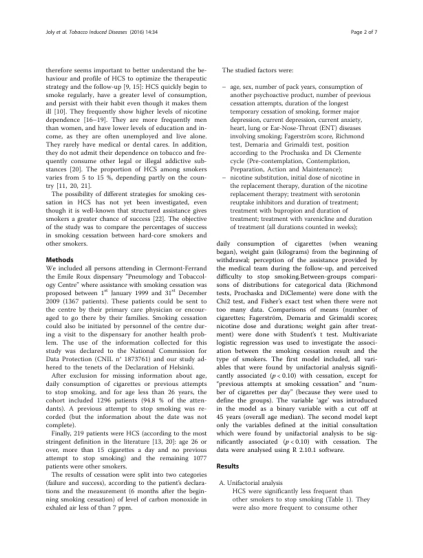

In [143]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))

img = plt.imread(f"{dir2publaynet}/train/{publaynet['images'][0]['file_name']}")
plt.imshow(img)
plt.axis('off')
plt.show()

In [144]:
import os

ds_dir = "C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS"
os.makedirs(ds_dir, exist_ok=True)

In [145]:
# #get the last id of the annotations from publaynet
# id = publaynet['annotations'][-1]['id']
# id

In [146]:
dataset = {"categories":publaynet["categories"].copy(),
            "images":[],
            "annotations":[]}

In [147]:
dataset["categories"].append({'supercategory': '', 'id': 6, 'name': 'signature'})
dataset["categories"].append({'supercategory': '', 'id': 7, 'name': 'stamp'})
dataset["categories"].append({'supercategory': '', 'id': 8, 'name': 'qr'})
dataset["categories"].append({'supercategory': '', 'id': 9, 'name': 'barcode'})
dataset["categories"]

[{'supercategory': '', 'id': 1, 'name': 'text'},
 {'supercategory': '', 'id': 2, 'name': 'title'},
 {'supercategory': '', 'id': 3, 'name': 'list'},
 {'supercategory': '', 'id': 4, 'name': 'table'},
 {'supercategory': '', 'id': 5, 'name': 'figure'},
 {'supercategory': '', 'id': 6, 'name': 'signature'},
 {'supercategory': '', 'id': 7, 'name': 'stamp'},
 {'supercategory': '', 'id': 8, 'name': 'qr'},
 {'supercategory': '', 'id': 9, 'name': 'barcode'}]

In [148]:
# iterate over the publaynet 100 first images and place 3 signatures on each image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


for i, sample in tqdm(enumerate(publaynet["images"])):    
    # plt.figure(figsize=(12, 7))
    
    page = cv2.imread(f"{dir2publaynet}/train/{sample['file_name']}")
    page = cv2.cvtColor(page, cv2.COLOR_BGR2RGB)
    
    n = np.random.randint(1, 4)
    img, dataset = add_stamps(n, page, stamps, dir2stamps, dataset, sample['id'])
    
    n = np.random.randint(1, 4)
    n = 1
    img, dataset = add_signatures(n, page, signatures, dir2signatures, dataset, sample['id'])
    
    n = np.random.randint(1, 4)
    img, dataset = add_qrs(n, img, qrs, dir2qrs, dataset, sample['id'])
    
    n = np.random.randint(1, 4)
    img, dataset = add_barcodes(n, img, barcodes, dir2barcodes, dataset, sample['id'])
    
    # Save the image
    os.makedirs(f"{ds_dir}/{split}", exist_ok=True)
    cv2.imwrite(f"{ds_dir}/{split}/{sample['file_name']}", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    # print(f"Image {sample['file_name']} saved")
    
    if i % 30 == 0:
        with open(f"{ds_dir}/{split}.json", 'w') as f:
            json.dump(dataset, f)
        print(f"Dataset saved at {ds_dir}/{split}.json") 

2it [00:00, 11.38it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


32it [00:04,  7.76it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


62it [00:07,  6.75it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


92it [00:11,  8.82it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


122it [00:14, 10.00it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


153it [00:18,  9.88it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


183it [00:21, 10.06it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


212it [00:25,  6.77it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


243it [00:28,  8.70it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


271it [00:31, 10.66it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


302it [00:35,  7.51it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


332it [00:39,  7.59it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


362it [00:42,  8.63it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


392it [00:45,  8.42it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


422it [00:49,  7.80it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


452it [00:53,  7.60it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


482it [00:56,  7.25it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


513it [01:00,  9.23it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


542it [01:03,  8.29it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


572it [01:07,  6.73it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


603it [01:11,  8.51it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


632it [01:14,  7.70it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


661it [01:17,  7.17it/s]

Dataset saved at C:/Users/Maria/OneDrive - UAB/Documentos/3r de IA/Synthesis project II/Github/Project_Synthesis2-/Datasets/Synthetics_DS/val.json


666it [01:18,  8.48it/s]


In [149]:
# open train.json and add the original annotations and images
with open(f"{dir2publaynet}/{split}_syn.json", 'r') as f:
    publaynet = json.load(f)

dataset2 = dataset.copy()
dataset2["images"] = publaynet["images"] + dataset["images"]
dataset2["annotations"] = publaynet["annotations"] + dataset["annotations"]

In [150]:
print(len(dataset2["images"]), len(dataset2["annotations"]))
print(len(publaynet["images"]), len(publaynet["annotations"]))
print(len(dataset["images"]), len(dataset["annotations"]))

666 9353
666 4660
0 4693


In [151]:
with open(f"{ds_dir}/{split}.json", 'w') as f:
    json.dump(dataset2, f)